##### Ricardo Luiz, Victor Pedro 

# Introdução
Quora é uma ferramenta _online_ de perguntas e respostas com o objetivo de compartilhar conhecimento de forma eficiente na internet. Um dos desafios desta plataforma é evitar que as mesmas perguntas sejam feitas repetidamente. Neste trabalho propomos uma solução à este desafio utilizando técnicas de mineração de textos aliadas à modelos de aprendizado de máquina para identificar se as perguntas são duplicadas ou não.

# Dataset
O dataset utilizado neste trabalho foi disponibilizado pelo Quora para uma competição de _data science_ organizado pelo _Kaggle_ [\[1\]](https://www.kaggle.com/c/quora-question-pairs). Este dataset é composto por aproximadamente quatrocentas mil tuplas contendo um par de perguntas e uma _label_ que define se o par de perguntas é duplicado ou não.

In [31]:
import pandas as pd
import csv

dataset = pd.read_csv('./datasets/dataset.csv', delimiter='\t')
dataset.head(10)

,id,q1id,q2id,q1,q2,y
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


Onde:
* **id**: É o identificador da linha
* **q1id, q2id**: O identificador de cada pergunta
* **q1, q2**: São os textos das perguntas
* **is_duplicate**: É a _label_ que treinaremos o modelo para predizer

## Analisando o dataset
Antes de dar processeguimento, é importante obter o máximo de informações possíveis sobre o dataset em que estamos trabalhando. Iremos verificar:
* A quantidade de tuplas no dataset
* A quantidade de perguntas duplicadas
* A quantidade de perguntas no dataset

In [23]:
import numpy as np

questions_ids = pd.Series(dataset['q1id'].tolist() + dataset['q2id'].tolist() )

print('Quantidades de pares para treinamento: ', len(dataset))
print("Quantidade de pares duplicados: %0.2f%%" % round(dataset['y'].mean()*100, 2))
print('Quantidade de questoes no dataset: ', len(np.unique(questions_ids)))
print('Quantidade de questoes que aparecem mais de uma vez: ', np.sum(questions_ids.value_counts() > 1))

Quantidades de pares para treinamento:  404349
Quantidade de pares duplicados: 36.93%
Quantidade de questoes no dataset:  789797
Quantidade de questoes que aparecem mais de uma vez:  13698


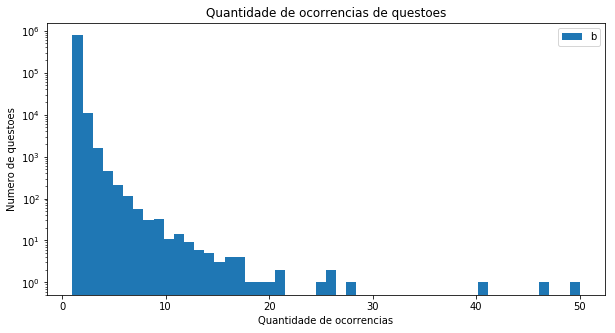

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.hist(questions_ids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Quantidade de ocorrencias de questoes')
plt.xlabel('Quantidade de ocorrencias')
plt.ylabel('Numero de questoes')
plt.legend('best')
print()

# Pré-processamento
Para treinarmos um modelo de aprendizado de máquina, é necessário que os dados passem por uma etapa de normalização, principalmente quando se trata de dados em formato não estruturado. Neste caso existem diversas ferramentas que auxiliam este trabalho.

## Remoção de contrações

In [132]:
import quora_dataset_builder as dsb

dataset['q1'] = dataset['q1'].apply(dsb.replace_contractions)
dataset['q2'] = dataset['q2'].apply(dsb.replace_contractions)
dataset.head()

,id,q1id,q2id,q1,q2,y
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0


## Tokenização e Stemming

In [133]:
dataset['q1'] = dataset['q1'].apply(dsb.stem)
dataset['q2'] = dataset['q2'].apply(dsb.stem)
dataset.head()

,id,q1id,q2id,q1,q2,y
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0
2,2,5,6,how can i increa the speed of my internet conn...,how can internet speed be increa by hack throu...,0
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0


Após o pré-processamento do dataset alguns fatores puderam ser analisados:
* Os tamanhos das questões 1 e 2
* As diferenças de tamanho entre as questões

In [52]:
 sizes = dataset.apply(
     lambda r: pd.Series([len(r.q1), len(r.q2), abs(len(r.q2) - len(r.q1)), r.y]),
     axis=1)
sizes.columns = ['q1', 'q2', 'diff', 'y']

Media das diferencas de tamanho em perguntas duplicadas: 11.93
Media das diferencas de tamanho em perguntas nao duplicadas: 21.90
Diferenca maxima de perguntas duplicadas: 183.00
Diferenca maxima de perguntas nao duplicadas: 1010.00
Diferenca minima de perguntas duplicadas: 0.00
Diferenca minima de perguntas nao duplicadas: 0.00


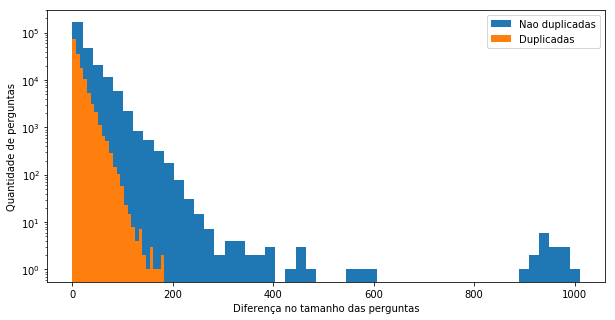

In [135]:
print("Media das diferencas de tamanho em perguntas duplicadas: {0:.2f}"
      .format(sizes[sizes.y == 1]['diff'].mean()))
print("Media das diferencas de tamanho em perguntas nao duplicadas: {0:.2f}"
      .format(sizes[sizes.y == 0]['diff'].mean()))
print("Diferenca maxima de perguntas duplicadas: {0:.2f}"
      .format(sizes[sizes.y == 1]['diff'].max()))
print("Diferenca maxima de perguntas nao duplicadas: {0:.2f}"
      .format(sizes[sizes.y == 0]['diff'].max()))
print("Diferenca minima de perguntas duplicadas: {0:.2f}"
      .format(sizes[sizes.y == 1]['diff'].min()))
print("Diferenca minima de perguntas nao duplicadas: {0:.2f}"
      .format(sizes[sizes.y == 0]['diff'].min()))

plt.figure(figsize=(10, 5))
plt.hist(sizes[(sizes.y==0)]['diff'], label='Nao duplicadas', bins=50)
plt.hist(sizes[sizes.y==1]['diff'], label='Duplicadas', bins=25)
plt.yscale('log', nonposy='clip')
plt.xlabel('Diferença no tamanho das perguntas')
plt.ylabel('Quantidade de perguntas')
plt.legend(loc='best')
plt.show()

# Preparando o modelo
A partir das informações obtidas sobre o conjunto de dados, a tarefa de extração de _features_ do dataset pode ser realizada, isto é, os dados textuais serão representados em um espaço vetorial, para que possam ser utilizados pelos algoritmos de aprendizado de máquina.

## Bag of words e N-grams
Bag of words (BoW) [\[2\]](https://link.springer.com/article/10.1007/s13042-010-0001-0) é um modelo de representação de textos no formato matricial, em que as linhas representam os textos e as colunas representam o conjunto de palavras únicas encontradas entre todos os textos. Nas células da matriz ficam armazenadas as frequencias de cada palavra em relação a cada texto. Existem duas formas comuns de se calcular a frequencia: a frequencia simples, que conciste em uma contagem simples, e a frequencia invertida (Tf-idf), que leva em consideração a frequencia em que cada palavra ocorre em todos os documentos. Neste trabalho a frequncia simples foi utilizada pois não houve diferença significativa nos testes com a frequencia invertida.

N-grams é a junção de `N` palavras em um token [\[3\]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.21.3248&rep=rep1&type=pdf). Esta técnica possibilita a preservação de dados contextuais, dado que BoW não leva a ordem em que as palavras aparecem nos textos em consideração. Neste trabalho um BoW com bigramas (2-grams) foi utilizado pois foi a modelagem que apresentou os melhores resultados nos testes preliminares.

In [ ]:
# n-gram range
ngram_range=(1,2)
# BoW algorithm instance
vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
# Building the features set using BoW with bigram
X = vectorizer.fit_transform(x)

### Redução de dimensionalidade
Neste trabalho utilizamos o método de redução de dimensionalidade **SVD** ao invés do **PCA** devido a esparsividade da matriz gerada pelo algoritmo BoW da biblioteca _sklearn_, e também ao fato do ***PCA*** exigir uma matriz com representação densa, o que ocasionaria problemas com limitação de memória _RAM_. [\[4\]](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)

Segundo a documentação da ferramenta, a quantidade de dimensões recomendada para análise semântica é 100 [\[4\]](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD), porém em nossos testes obtivemos melhores resultados com 300 dimensões.

In [ ]:
# sklearn SVD instance
svd = TruncatedSVD(n_components=300)
# fit the features set using svd
X = svd.fit_transform(X)

**Unindo os textos:** As features foram representadas por duas formas: _Bag of words_. Para isto, a abordagem adotada foi a concatenação das duas perguntas resultando em um único texto, que posteriormente será utilizado para a criação das _features_, mantendo a _label_ `is_duplicated` como classe.

Chamaremos este conjunto de _features_ formado pelo BoW com as dimensões reduzidas pelo SVD de **fs-1**.

**Variação:** No caso da _Bag of words_, foi também feita uma modelagem aplicado as etapas de pré-processamento e redução de dimensionalidade separadamente para cada pergunta, e após o processos os vetores foram concatenados.

Chamaremos esta variação do conjunto de _features_ formado pelo BoW com as dimensões reduzidas pelo SVD de **fs-2**.


## Word2Vec (GloVe)
Outra forma de extração de _features_ em dados textuais é a utilização de modelos de aprendizado de máquina, que dado um conjunto de dados de entrada, geram um espaço vetorial de dimensionalidade reduzida, em que cada palavra é um vetor deste espaço. Esta representação guarda informações contextuais de uma palavra baseado em sua aparição no conjunto de entrada [\[5\]](https://arxiv.org/abs/1402.3722). 
O algoritmo mais populares e que foi utilizado neste trabalho é o Word2vec [\[5\]](https://arxiv.org/abs/1402.3722), juntamente com o modelos pré-treinados pertencentes ao projeto _GloVe_, criado na universidade de Stanford [\[6\]](https://nlp.stanford.edu/projects/glove/).

A escolha do _GloVe_ se deve ao fato da disponibilização de modelos com dimensões variáveis, 50, 100, 200 e 300. Estes modelos foram gerados a partir de dados da _Wikipedia_, e possuem 6B de tokens e 400 mil vocábulos. Após testes preliminares, o modelo com 300 dimensões foi o que apresentou melhores resultados.

In [ ]:
# convert GloVe to Word2Vec format
glove2word2vec('datasets/glove.6B.300d.txt', 'datasets/glove.6B.300d.word2vec')
# load glove in word2vec format
model = KeyedVectors.load_word2vec_format(
        'datasets/glove.6B.300d.word2vec',
        binary=False)
# ...
# divide a row (tuple) in an array of words
words = tokenizer.tokenize(row[1])
# pick only the words in the glove vocabulary
filtered_words = [word for word in words if word in model.vocab]

for word in filtered_words:
    #get the vector representation in pre-trained glove
    word_vector = model.word_vec(word)
    # insert the word vector in the features set
    X[row_index] = add(X[row_index], word_vector)

# ...
# divide a row by the norm
for row in range(X.shape[0]):
    X[row] = divide(X[row], norm(X[row]))  

Chamaremos este conjunto de _features_ formado pela representação vetorial das palavras do GloVe de **fs-3**.

# Modelos de aprendizado

Os classificadores utilizados nos experimentos foram o Random Forest e XGboost, ambos baseados em árvores de decisão. O método de avaliação dos modelos gerados foi o _cross-validation_ com 5 _folds_, utilzando a métrica _Log Loss_ [\[7\]](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) como parâmetro de avaliação. Adicionalmente, uma matriz de confusão para um dos testes de cada classificador támbem foi apresentada juntamente com a acurácia.

## Naive bayes
O algoritmo Naive bayes foi utilizado como um _baseline_ para comparação do desempenho dos próximos algoritmos.

In [2]:
# Naive bayes classifier
model = GaussianNB()
# train the model using cross-validation with 5 folds in parallel
scores = cross_val_score(model, X, y, cv=n_folds, n_jobs=-1, scoring='neg_log_loss')

### Resultados

|Log Loss | Feature set |
| -------- | ----------- |
|1.505620 |   **fs-1** |
|1.780609 |   **fs-2** |
|1.591343 |   **fs-3** |

#### Matriz de confusão **fs-2**

| |  |  |
|---|---|---|
|**0**  | 36683 | 14091 |
|**1**  | 16612 | 13484|

**Acurácia: 62%**

## Random Forest
Os experimentos com o classificador Random Forest [\[8\]](http://ai2-s2-pdfs.s3.amazonaws.com/6e63/3b41d93051375ef9135102d54fa097dc8cf8.pdf) consistiram na variação do número de árvores, 100 e 200, pois alguns dos parâmetros são definidos automaticamente por meio de heurísticas. Os demais parâmetros não foram ajustados devido ao fato de que em testes preliminares em uma amostra do dataset, não houve ganhos em relação aos valores padrões.

Não prosseguimos com os testes utilizando este modelo pois comparado ao XGBoost, este obteve rendimento inferior.

In [ ]:
# Instance the RandomForest classifier with 100 trees
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# train the model using cross-validation with 5 folds in parallel
scores = cross_val_score(model, X, y, cv=n_folds, n_jobs=-1, scoring='neg_log_loss')

### Resultados
#### Tabela de resultados Validação Cruzada
| n_estimators | Log Loss | Feature set |
| ------------ | -------- | ----------- |
| 100          | 0.637080 |   **fs-1** |
| 200          | 0.605942 | **fs-1** |
| 100          | 0.492744 | **fs-2** |
| 200          | 0.488447 | **fs-2** |
| 100          | 0.577895 | **fs-3** |

#### Matriz de confusão **fs-2** (n_estimators = 200)

| |  |  |
|---|---|---|
|**0**  | 47837 | 3235 |
|**1**  | 14446 | 15352|

**Acurácia: 79%**

## XGBoost
Os experimentos com o XGBoost [\[9\]](http://dl.acm.org/citation.cfm?id=2939785), classificador escalável baseado em árvores de decisão, foram realizados variando tanto a matriz de features quanto os parâmetros do algoritmos. Testes preliminares com uma amostra do dataset mostraram que os parâmetros do classificador que trouxeram os melhores resultados foram os seguintes: 

* `max_depth=7`
* `base_score=0.2`
* `subsample=0.6`

Com esses parâmetros fixados, foram realizados testes com o dataset completo variando o número de árvores. A quantidades de árvores testadas foram as seguintes: 100, 200, 500 e 1000.

In [ ]:
# Instance the XGBoost classifier with n_estimators
model = XGBClassifier(n_estimators=estimator, max_depth=depth, base_score=score, subsample=sub_sample)
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='neg_log_loss')

### Resultados
| n_estimators | Log Loss | Feature set |
| ------------ | -------- | ----------- |
| 100          | 0.568720 |   **fs-1** |
| 200          | 0.480609 | **fs-1** |
| 500          | 0.451343 | **fs-1** |
| ***1000***         | ***0.435240*** | **fs-1** |
| 100         | 0.620326 | **fs-2** |
| 200         | 0.618113 | **fs-2** |
| 500         | 0.616009 | **fs-2** |
| 1000         | 0.590790 | **fs-2** |
| 100          | 0.577797 |   **fs-3** |

#### Matriz de confusão **fs-2** (n_estimators = 1000)

| |  |  |
|---|---|---|
|**0**  | 45418 | 5356 |
|**1**  | 21994 | 8102|

**Acurácia: 66%**

### Conclusão

Este trabalho mostrou diferentes modelagens para o problema de detecção de questões duplicadas, assim como um comparativo entre um conjunto de classificadores utilizados para a geração de modelos de detecção para o problema. Dentre os classificadores testados, o XGboost foi o que apresentou os melhores resultados, gerando um _Log Loss_ de aproximadamente **0.44**.
Para trabalhos futuros, ficam indicados testes mais extensivos com os classificadores testados, a realização de outras modelagens para o problema, e também a realização de testes com outros classificadores.